In [34]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    source('../utils_mapping.R')
    source('../utils_plotting.R')
})


In [35]:
# obj <- readRDS('/data/srlab2/ik936/Roche/data/cache/mouse_query_joint.rds')

In [36]:
# dname <- '/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/'
# if (!dir.exists(dname)) dir.create(dname)
# obj %>% imap(function(.obj, .name) {
#     message(.name)
#     saveRDS(.obj, paste0(dname, .name, '.rds'))
#     return(.name)
# })


In [37]:
dname <- '/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/'
# fields_load <- c('meta_data', 'effects_hs', 'U', 'masc')
fields_load <- c('meta_data', 'effects_hs', 'presto_hs', 'U', 'masc')
obj <- map(fields_load, function(name) {
    readRDS(file.path(dname, paste0(name, '.rds')))
})
names(obj) <- fields_load


In [38]:
obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('Synovium_sta', 'Synovium_cia', 'Gut', 'Lung')))


obj$meta_data <- obj$meta_data %>% 
    dplyr::mutate(LibraryID = case_when(
        grepl('Synovium', Tissue) ~ Status_tissue, 
        LibraryID == 'GSM3891612' ~ 'Bleo1',
        LibraryID == 'GSM3891613' ~ 'Bleo2',
        LibraryID == 'GSM3891616' ~ 'HL1',
        LibraryID == 'GSM3891617' ~ 'HL2',
        TRUE ~ LibraryID
    )) %>% 

    ### NOTE: NEED TO FIX THIS IN THE ORIGINAL ANALYSIS!!!!!!
    dplyr::mutate(LibraryID = case_when(
        Tissue == 'Synovium_cia' ~ gsub('^.*_(.*)$', '\\1', CellID), 
        TRUE ~ LibraryID
    ))


In [39]:
contrasts_mat <- make_contrast.presto(obj$presto_hs, 'Cluster', 'Tissue')
obj$effects_hs <- contrasts.presto(obj$presto_hs, contrasts_mat, one_tailed = FALSE) %>% 
    tidyr::separate(contrast, c('Cluster', 'Tissue'), sep = '\\|', remove = FALSE) %>% 
    arrange(pvalue)


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 14 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14].”


In [40]:
effects_ref_marginal <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_marginal.rds')
effects_ref_nested <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds')


Nice cluster names

In [41]:
meta_hs <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/meta_data.rds') %>% 
    dplyr::select(Cluster, Cluster_name) %>% 
    unique() %>% 
    dplyr::mutate(Cluster = paste0('C', Cluster))


In [42]:
# ## Presto stats for reference
# .x <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts.rds')
# effects_ref_marginal <- .x$effects_marginal
# effects_ref_nested <- .x$effects_nested
# rm(.x); gc()

# c('effects_marginal', 'effects_nested')

In [43]:
## time series analysis 
tc_enrich <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_time_enrichment.rds')
tc_meta <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_time_meta.rds')
tc_expression <- readRDS('/data/srlab2/ik936/Roche/data/cache/gut_time_expression.rds')


# Numbers

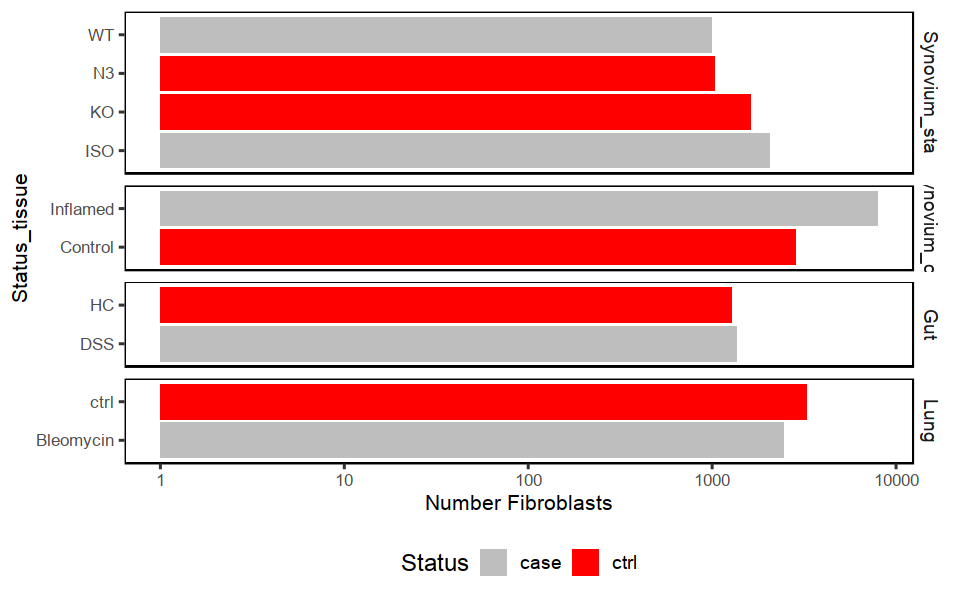

In [44]:
fig.size(5, 8)
p1 <- data.table(obj$meta_data)[, .N, by = .(LibraryID, Status, Status_tissue, Tissue)] %>% 
    ggplot(aes(Status_tissue, N, fill = Status)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        scale_y_log10() + 
        scale_fill_manual(values = c('grey', 'red')) + 
        labs(y = 'Number Fibroblasts') + 
#         facet_wrap(~Tissue, ncol = 1, scales = 'free_y') + 
        facet_grid(Tissue~., scales = 'free', space = 'free') + 
        coord_flip() + 
        theme(legend.position = 'bottom') + 
        NULL

p1


# UMAP (cluster) 

In [45]:
cluster_levels <- meta_hs %>% 
    arrange(as.integer(gsub('C', '', Cluster))) %>% 
    with(Cluster_name)


Joining, by = "Cluster"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


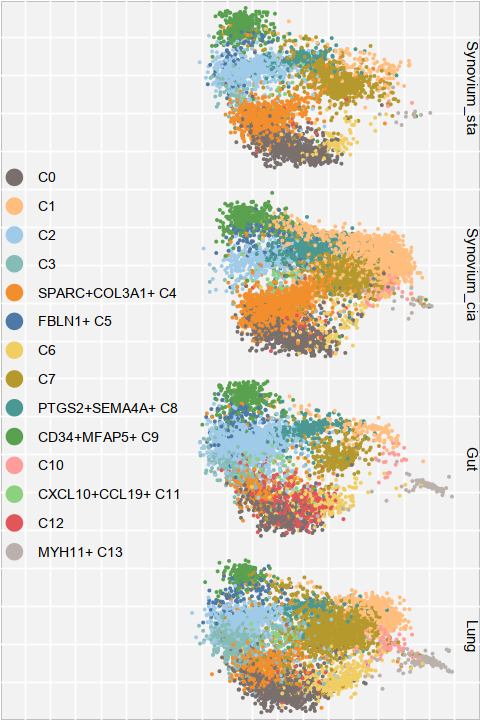

In [46]:
fig.size(6, 4)

p2_1 <- do_scatter(
    obj$U, 
    obj$meta_data %>% 
        dplyr::left_join(meta_hs) %>% 
        dplyr::mutate(Cluster_name = factor(Cluster_name, levels = cluster_levels)),
    'Cluster_name',
    base_size = 12, pt_size = 8, 
    pt_shape = 16, point_size = .5, 
#     do_raster = TRUE, h = 3, w = 4, ## Not working for some reason ... 
    palette_use = palette_global[cluster_levels], 
    do_labels = FALSE, no_guides = FALSE
) + 
    scale_x_continuous(breaks = c(-0.5, 0, 0.5)) + 
    scale_y_continuous(breaks = c(-0.5, 0, 0.5)) + 
    facet_grid(Tissue~., scales = 'free', space = 'free') + 
    theme_void() + 
    theme(
        strip.text = element_text(angle = 270), 
        legend.position = 'left',
        legend.title = element_blank(),
        legend.text = element_text(size = 8)
    ) + 

#     theme(
#         axis.text.y = element_blank(),
#         axis.ticks.y = element_blank(),
#         axis.title.y = element_blank()
#     ) + 
    NULL

p2_1 <- remove_strip_box(p2_1)
plot(p2_1) 


# Barplots (cluster) 

In [47]:
# fig.size(4, 6)
# p3 <- obj$meta_data %>% 
#     with(table(Tissue, Cluster)) %>% 
#     prop.table(1) %>% 
#     data.table() %>% 
#     subset(N > 0) %>% 
#     dplyr::mutate(Tissue = factor(Tissue, c('Synovium', 'Gut', 'Lung'))) %>% 
#     ggplot(aes(Tissue, N, fill = Cluster)) + 
#         geom_bar(stat = 'identity', position = position_fill()) + 
# #         scale_fill_tableau('Tableau 20') + 
#         scale_fill_manual(values = palette_global) + 
#         coord_flip() + 
#         labs(y = 'Fraction of Cells') + 
#         facet_grid(Tissue~., scales = 'free', space = 'free') + 
# #         scale_y_continuous(labels = scales::percent) + 
#         guides(fill = FALSE) + 
#         theme(
#             axis.text.y = element_blank(),
#             axis.ticks.y = element_blank(),
#             axis.title.y = element_blank(),
#             axis.text.x = element_text(angle = -90, hjust = 1)
#         ) + 
#         NULL

# p3


# Conservation (heatmap) 

In [48]:
df_mm <- obj$effects_hs %>% 
    dplyr::mutate(Cluster = gsub('C', 'mm_', Cluster)) %>% 
    dplyr::mutate(Cluster = paste0(Tissue, '_', Cluster)) %>% 
    dplyr::select(Cluster, zscore, feature) %>% 
    tidyr::spread(Cluster, zscore) %>% 
    tibble::column_to_rownames('feature')

## Compare to tissue-specific effects
df_hs <- effects_ref_nested %>%
    subset(!Tissue %in% c('SalivaryGland')) %>% 
    dplyr::mutate(Cluster = paste0(Tissue, '_', Cluster)) %>% 
    dplyr::select(Cluster, zscore, feature) %>% 
    tidyr::spread(Cluster, zscore) %>% 
    tibble::column_to_rownames('feature')

genes_use <- intersect(rownames(df_mm), rownames(df_hs))
cormat <- cor(df_mm[genes_use, ], df_hs[genes_use, ])
o_row <- order(as.integer(gsub('.*?(\\d+)', '\\1', rownames(cormat))))
o_column <- order(as.integer(gsub('.*?(\\d+)', '\\1', colnames(cormat))))
cormat <- cormat[o_row, o_column]


In [49]:
anno_row <- data.frame(
    Cluster = gsub('^(.*?)_(.*?)_(\\d+)', '\\3', rownames(cormat)),
    Tissue = gsub('^(.*?)_(.*?)_(\\d+)', '\\1', rownames(cormat))
) %>% 
    dplyr::mutate(Tissue = gsub('_sta|_cia', '', Tissue))

anno_col <- data.frame(
    Cluster = gsub('^(.*?)_(\\d+)', '\\2', colnames(cormat)),
    Tissue = gsub('^(.*?)_(\\d+)', '\\1', colnames(cormat))
)


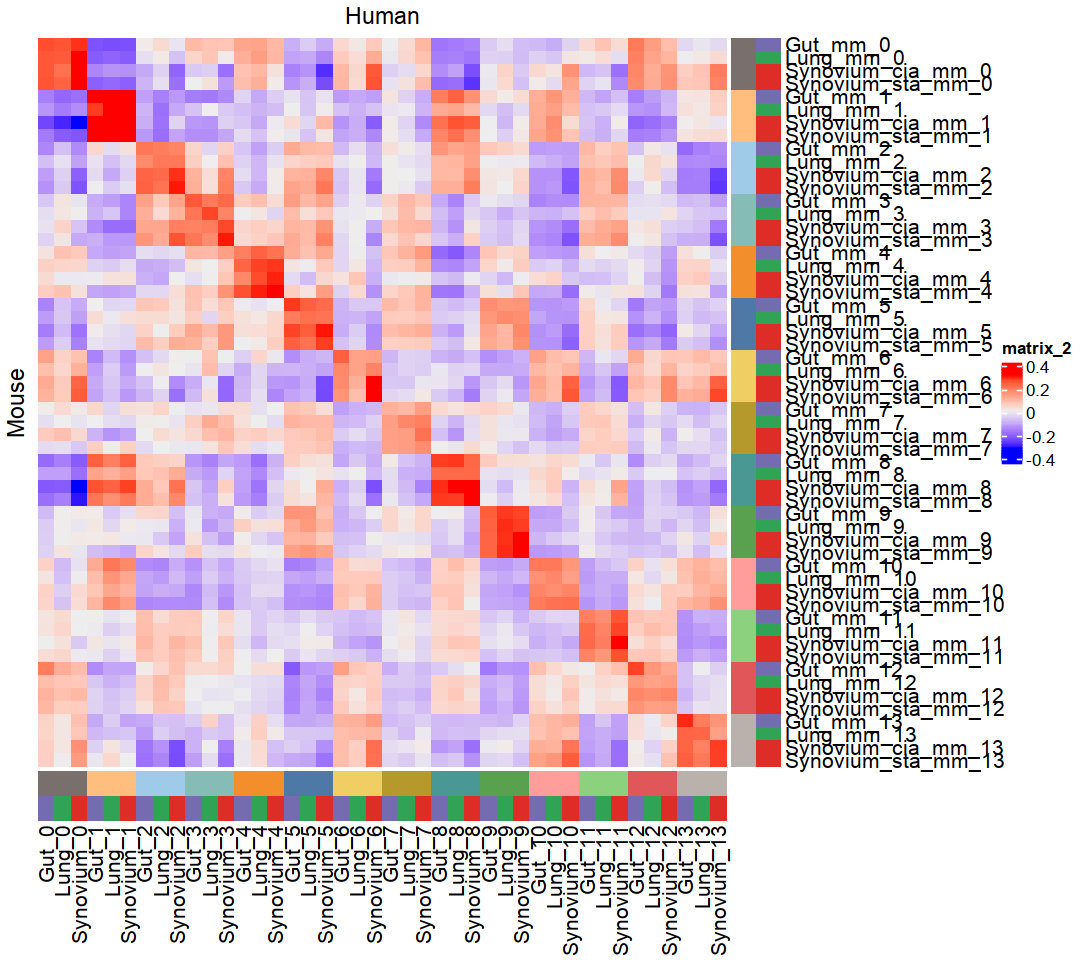

In [50]:
fig.size(8, 9)

ht_opt(RESET = TRUE)
ht_opt("heatmap_column_names_gp" = gpar(fontsize = 12))

h1 <- Heatmap(
    cormat,
    cluster_rows = FALSE, cluster_columns = FALSE,
    row_title = 'Mouse', column_title = 'Human',
    bottom_annotation = columnAnnotation(
        df = anno_col,
        show_legend = FALSE,
        col = palette_heatmap,
        show_annotation_name = FALSE
    ),
    right_annotation = rowAnnotation(
        df = anno_row,
        show_legend = FALSE,
        col = palette_heatmap,
        show_annotation_name = FALSE
    ),
#     use_raster = TRUE, raster_device = "CairoJPEG"
)

p4 <- grid.grabExpr(draw(h1))

h1


# Proportions barplots 

Joining, by = "LibraryID"

Joining, by = "Cluster"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


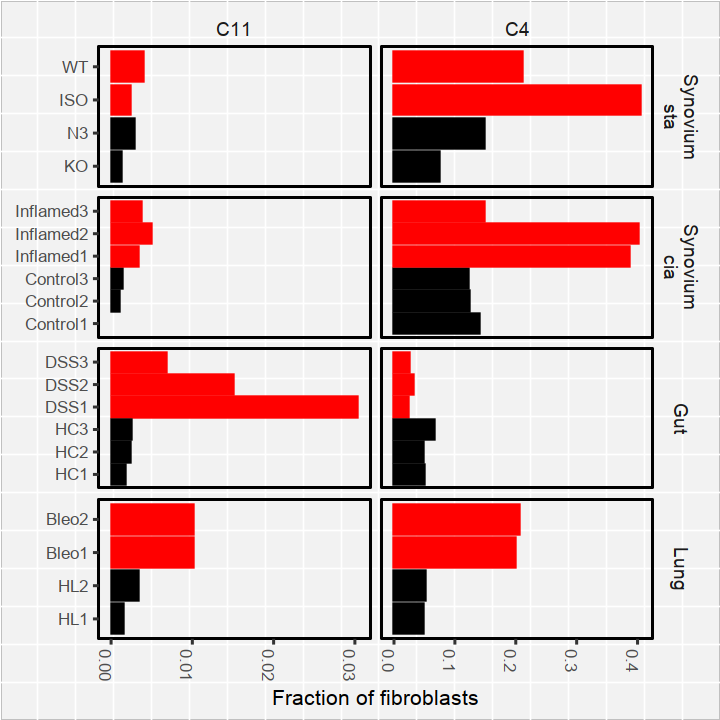

In [51]:
fig.size(6, 6)
p6 <- obj$meta_data %>% 
    with(table(LibraryID, Cluster)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
    dplyr::left_join(unique(dplyr::select(obj$meta_data, LibraryID, Status, Tissue, Status_tissue))) %>% 
    subset(Cluster %in% c('C4', 'C11')) %>% 
    dplyr::mutate(Status = factor(Status, c('ctrl', 'case'))) %>% 
    dplyr::left_join(meta_hs) %>% 
#     dplyr::mutate(Cluster_name = gsub(' ', '\n', Cluster_name)) %>% 
    dplyr::mutate(Tissue = gsub('_', '\n', Tissue)) %>% 
    dplyr::mutate(Tissue = factor(Tissue, c('Synovium\nsta', 'Synovium\ncia', 'Gut', 'Lung'))) %>% 
    ggplot(aes(reorder(LibraryID, as.integer(Status)), N, fill = Status, color = Status)) + 
        geom_bar(stat = 'identity') + 
        facet_grid(Tissue~Cluster, scales = 'free') + 
        coord_flip(clip = 'off', ) + 
        scale_color_manual(values = c('black', 'red')) + 
        scale_fill_manual(values = c('black', 'red')) + 
        guides(fill = FALSE, color = FALSE) +
        labs(x = 'Library', y = 'Fraction of fibroblasts') + 
        theme(
            axis.text.x = element_text(angle = -90, hjust = 1),
            axis.title.y = element_blank() 
        ) + 
        NULL


p6 <- remove_strip_box(p6)
plot(p6)


# Gut time enrichment

In [52]:
modules_df <- tribble(
    ~Module, ~Phase,
    'M1', 'Acute',
    'M3', 'Acute',
    'M4', 'Acute',
    'M5', 'Early',
    'M5', 'Recovery',
    'M6', 'Recovery',
    'M9', 'Early'
)

In [53]:
tc_enrich %>% 
    subset(pathway == '6') %>% 
    select(-leadingEdge) %>% 
    arrange(-NES) %>% 
    head(3)
    

Cluster,database,pathway,pval,padj,ES,NES,nMoreExtreme,size
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
13,6,6,4.072822e-05,0.0003665540,0.3368687,1.478198,1,573
1,6,6,1.999960e-05,0.0001799964,0.3580219,1.478153,0,573
7,6,6,2.760906e-04,0.0006212038,0.2452707,1.397932,0,573


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


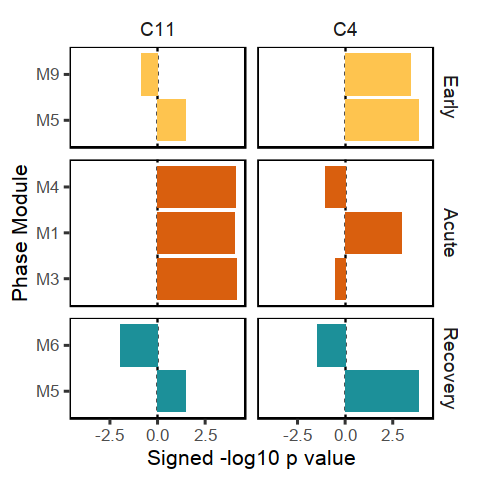

In [54]:
# fig.size(8, 4)
fig.size(4, 4)
p7 <- tc_enrich %>% 
    dplyr::select(-leadingEdge) %>% 
    dplyr::mutate(SCORE = sign(NES) * -log10(pval)) %>%
#     subset(Cluster %in% c('4', '11', '0', '12', '13')) %>% 
#     dplyr::mutate(Cluster = factor(Cluster, c(
# #         '7', ## ubiquitous
#         '0', '4', ## early 
#         '13', ## early and recovery (myofibroblast)
#         '11', '12' ## acute 
#     ))) %>% 
    subset(Cluster %in% c('4', '11')) %>% 
    dplyr::mutate(pathway = paste0('M', pathway)) %>% 
    inner_join(modules_df, by = c('pathway' = 'Module')) %>% 
    dplyr::mutate(pathway = factor(pathway, c('M5', 'M9', 'M3', 'M1', 'M4', 'M6'))) %>% 
    dplyr::mutate(Phase = factor(Phase, c('Early', 'Acute', 'Recovery'))) %>% 
    dplyr::mutate(Cluster = paste0('C', Cluster)) %>% 
    ggplot(aes(pathway, SCORE, fill = Phase)) + 
#         geom_hline(yintercept = c(log10(.05), 0, -log10(.05)), linetype = 2) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        facet_grid(Phase~Cluster, scales = 'free', space = 'free') + 
#         facet_grid(Cluster~Phase, scales = 'free', space = 'free') + 
#         facet_wrap(~Cluster, ncol = 1, scales = 'free_y') + 
#         scale_fill_tableau() + 
        labs(y = 'Signed -log10 p value', x = 'Phase Module') + 
#         labs(y = 'Normalized Enrichment Score', x = 'Phase Module') + 
#         theme(legend.position = 'top') + 
        coord_flip() + 
        guides(fill = FALSE) + 
        ylim(-4.2, 4.2) + 
        NULL

p7 


# Gut time line plots

In [55]:
genes_test_df <- tibble(
    ## Acute 
    M1 = c('Ccl8', 'Cxcl10', 'Cxcl9'), # 'Irf8', 'C6'),
    M3 = c('Cd74', 'H2-DMa', 'Stat1'), # 'H2-Ab1', 'Gbp2'),
    M4 = c('C3', 'Vcam1', 'Tnfsf13b'), # 'Tnfrsf4', 'Cfb'),

    ## Early 
    M5 = c('Wfdc1', 'Col3a1', 'Thy1'), #, 'Col11a1', 'Pmepa1'),
    M9 = c('Sfrp2', 'C1qtnf2', 'Crlf1')
) %>% 
    tidyr::gather(module, feature) %>% 
    dplyr::mutate(phase = case_when(
        module %in% c('M1', 'M3', 'M4') ~ 'acute',
        module %in% c('M5', 'M9') ~ 'early',
        module %in% c('M6') ~ 'resolution',
    ))


In [56]:
data_df <- tc_meta %>% 
    ## ignores autoregression, not great but maybe OK? 
    dplyr::mutate(day_of_dss = factor(day_of_dss)) %>% 
    dplyr::mutate(day_of_dss = relevel(day_of_dss, ref = '0')) %>% 
    cbind(t(tc_expression[genes_test_df$feature, ])) %>% ## Gaussian (LM)
    dplyr::select(-title, -geo_accession, -flowcell, -group, -sequencing_lane, -sequencing_run_number, -phase) %>% 
    tidyr::gather(feature, val, -description, -cage, -day_of_dss, -sex) %>%
    inner_join(genes_test_df) %>% 
    dplyr::mutate(time = as.numeric(as.character(day_of_dss))) %>% 
    dplyr::mutate(feature = glue::glue('{module}:{feature}')) %>% 
    identity()


Joining, by = "feature"



In [57]:
feature_levels <- data_df  %>% 
    dplyr::select(module, feature) %>% 
    unique() %>% 
    dplyr::mutate(module = factor(module, c('M5', 'M9', 'M1', 'M3', 'M4'))) %>% 
    arrange(module) %>% 
    with(feature)


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



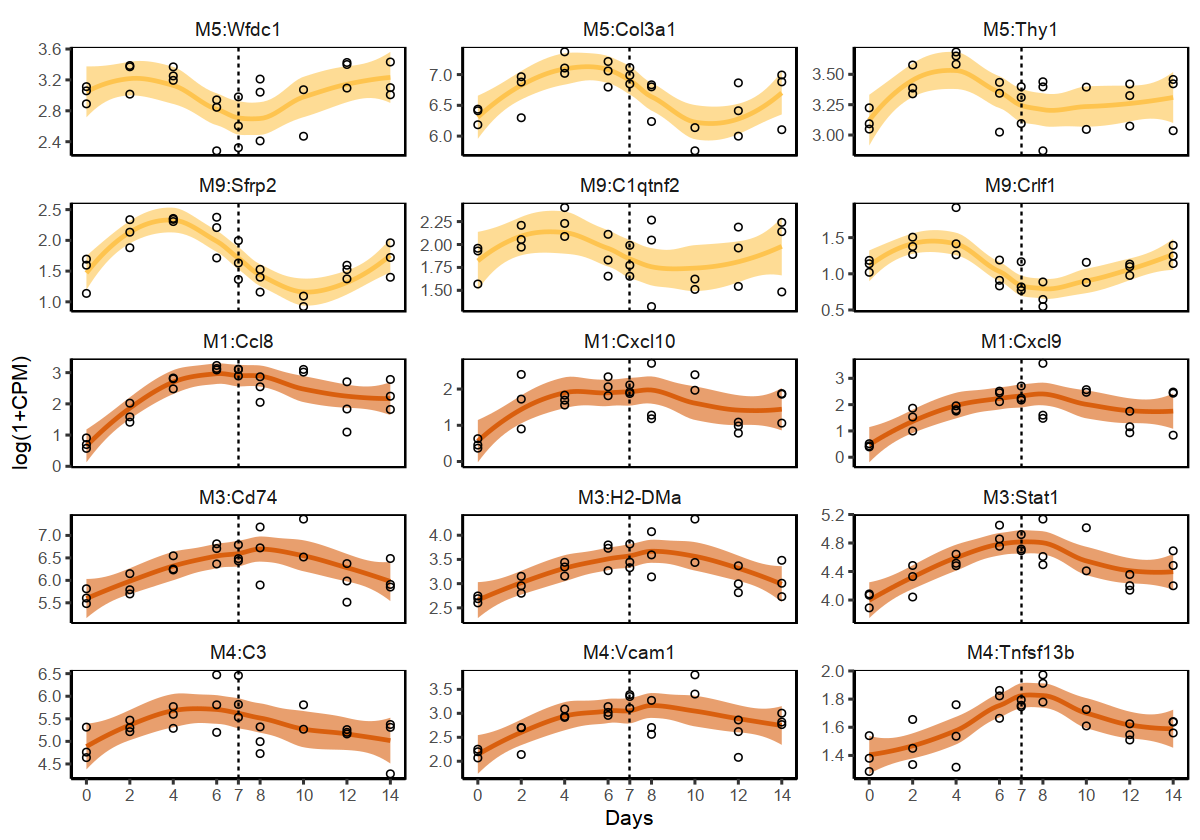

In [58]:
fig.size(7, 10)
p8 <- data_df %>% 
    dplyr::mutate(feature = factor(feature, feature_levels)) %>% 
    ggplot(aes(time, val)) + 
        geom_smooth(aes(x = time, color = phase, fill = phase), alpha = .6) + 
        geom_point(shape = 21) + 
#         geom_point(shape = 21) + 
        theme(
            axis.line = element_line()
        ) + 
        geom_vline(xintercept = c(7), linetype = 2, color = 'black') + 
#         geom_vline(xintercept = c('2', '7'), linetype = 2, color = 'red') + 
        facet_wrap(~feature, scales = 'free_y', nrow = 5) + 
#         facet_wrap(~feature, scales = 'free_y', nrow = 5) + 
        guides(color = FALSE, fill = FALSE) + 
#         geom_smooth(aes(x = time), color = 'red', alpha = .2, fill = 'red') + 
        labs(y = 'log(1+CPM)', x = 'Days') + 
        scale_x_continuous(breaks = c(0, 2, 4, 6, 7, 8, 10, 12, 14)) + 
        NULL

 p8 

# Cartoon

In [62]:
library(png)
g0 <- readPNG('/data/srlab2/ik936/Roche/manuscript/figures/cartoon_mouse_models.png') %>% 
    rasterGrob(interpolate = TRUE)


# Panels

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



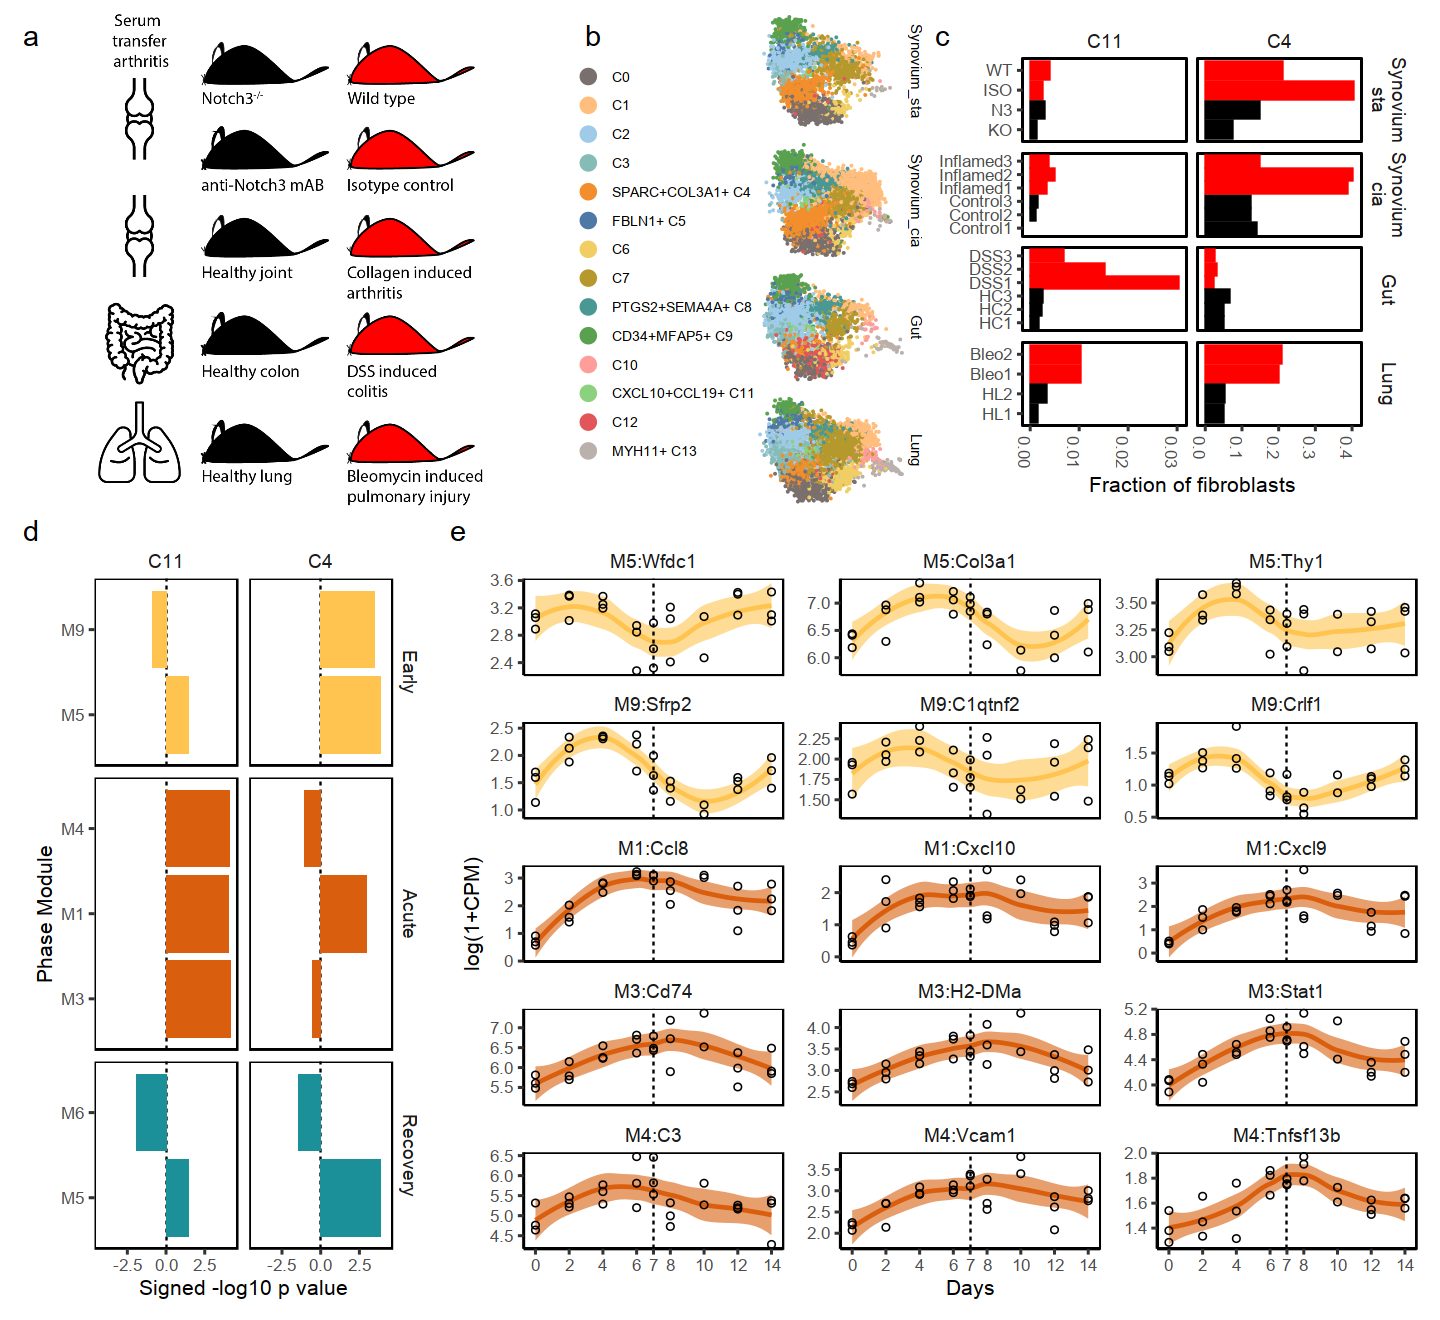

In [63]:
fig.size(11, 12)
(
    ## Row 1
    (
        (
            wrap_elements(full = g0) | 
#             wrap_elements(full = grid::textGrob('Cartoon\nto\ndescribe\nmouse\nExperiments')) | 
            wrap_elements(full = p2_1) | wrap_elements(full = p6)        
        ) 
#         p2_1 | p3
    ) + 
#     plot_layout(widths = c(1.5, 1)) 
    plot_layout(widths = c(1.5, 1, 1.5)) 
) / (
    (p7 | p8 ) + plot_layout(widths = c(1, 3))
#     ((p6 / p7) + plot_layout(heights = c(3, 1)) | p8 ) + plot_layout(widths = c(1, 1.8))
) + 
    plot_layout(heights = c(1, 1.5)) + 
    plot_annotation(tag_levels = 'a')


In [64]:
ggsave(
    filename = '/data/srlab2/ik936/Roche/manuscript/figures/Figure8.pdf', 
    units = 'in', device = 'pdf', 
    height = 11, width = 12,
    useDingbats = FALSE
)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

